In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import random
import urllib
import cv2

from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from tensorflow.keras import layers

from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LeakyReLU

import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil

import matplotlib.pyplot as plt
import numpy as np
import itertools

from keras.layers import Lambda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/My Drive/Colab Notebooks/erg8_patern_recognition_2021/Dataset"

In [ ]:
img_height = 100
img_width  = 100
classes    = ['0','1','2','3','4','5','6','7','8','9']
batch_size = 150

In [ ]:
# Dataset = Dataset.reshape(-1, 100, 100, 1)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale")

Found 2059 files belonging to 10 classes.
Using 1442 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale")

Found 2059 files belonging to 10 classes.
Using 411 files for validation.


In [ ]:
num_classes = 10

min=-1
max=1

filepath = "weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=True, 
                             mode='auto', save_freq='epoch')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, 
                      verbose=1, mode='auto')
model = tf.keras.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(64,(1,1),activation="relu"),
  layers.Conv2D(128,(3,3),activation="relu"),
  layers.MaxPooling2D(pool_size=(4,4)),
  layers.BatchNormalization(),
  layers.Conv2D(256,(1,1),activation="relu"),
  layers.BatchNormalization(),
  layers.Conv2D(512,(1,1),activation="relu"),
  layers.Conv2D(1024,(3,3),activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(6,6)),

  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(32, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=500,
  callbacks=[checkpoint, early]
)

Epoch 1/500
10/10 [==============================] - 571s 18s/step - loss: 2.1253 - accuracy: 0.2976 - val_loss: 6.2163 - val_accuracy: 0.0900

Epoch 00001: val_accuracy improved from -inf to 0.09002, saving model to weights.best.hdf5
Epoch 2/500
10/10 [==============================] - 7s 580ms/step - loss: 0.9499 - accuracy: 0.7539 - val_loss: 6.0915 - val_accuracy: 0.1022

Epoch 00002: val_accuracy improved from 0.09002 to 0.10219, saving model to weights.best.hdf5
Epoch 3/500
10/10 [==============================] - 7s 584ms/step - loss: 0.5847 - accuracy: 0.8612 - val_loss: 3.4248 - val_accuracy: 0.0949

Epoch 00003: val_accuracy did not improve from 0.10219
Epoch 4/500
10/10 [==============================] - 7s 591ms/step - loss: 0.3775 - accuracy: 0.9236 - val_loss: 2.2940 - val_accuracy: 0.1241

Epoch 00004: val_accuracy improved from 0.10219 to 0.12409, saving model to weights.best.hdf5
Epoch 5/500
10/10 [==============================] - 7s 591ms/step - loss: 0.2686 - accura

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale")

model.load_weights("weights.best.hdf5")
score = model.evaluate(test_ds)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Found 2059 files belonging to 10 classes.
Using 205 files for validation.
2/2 [==============================] - 3s 3s/step - loss: 0.1444 - accuracy: 0.9805
Test score:  0.1444152146577835
Test accuracy:  0.9804878234863281


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 256)       33024     
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 256)      

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

predictions = np.array([])
true_labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, model.predict_classes(x)])
  true_labels = np.concatenate([true_labels, y.numpy()])

precisions, recall, f1_score, samples_per_class = metrics.precision_recall_fscore_support(true_labels, predictions,labels = [0,1,2,3,4,5,6,7,8,9])
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
print('Precision :',precisions,'\nRecall :',recall,'\nF1_Score :',f1_score,'\nSamples per class :',samples_per_class)

Found 2059 files belonging to 10 classes.
Using 205 files for validation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Precision : [1.         0.94444444 0.96428571 1.         1.         1.
 0.96296296 0.9375     1.         1.        ] 
Recall : [1.         1.         0.96428571 1.         0.94444444 1.
 1.         0.9375     0.95454545 1.        ] 
F1_Score : [1.         0.97142857 0.96428571 1.         0.97142857 1.
 0.98113208 0.9375     0.97674419 1.        ] 
Samples per class : [24 17 28 12 18 22 26 16 22 20]


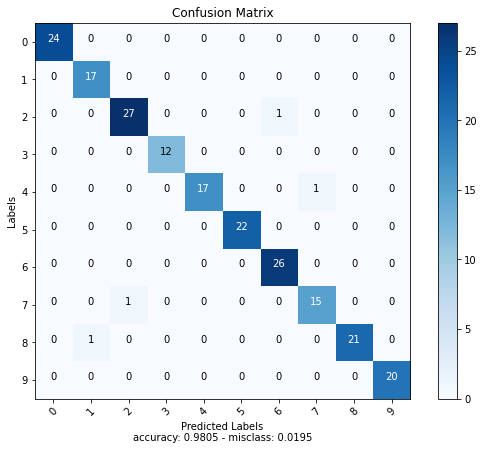

In [ ]:
target_names=['0','1','2','3','4','5','6','7','8','9']
# plot_confusion_matrix(confusion_matrix, target_names, title='Confusion matrix', cmap=None, normalize=None)
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix).astype('float')
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = confusion_matrix.max() / 2
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(confusion_matrix[i, j]),
              horizontalalignment="center",
              color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Labels')
plt.xlabel('Predicted Labels\naccuracy: {:0.4f} - misclass: {:0.4f}'.format(accuracy, misclass))
plt.show()

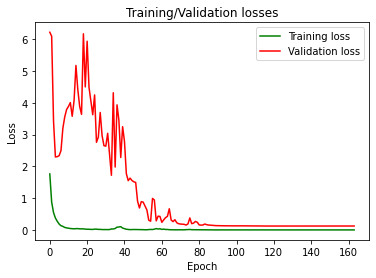

In [ ]:
epochs = range(0,len(history.history['loss']))
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('Training/Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

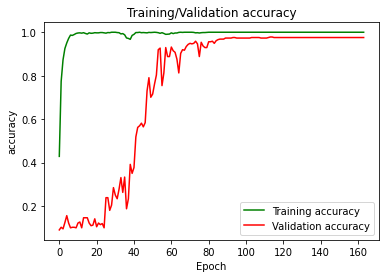

In [ ]:
epochs = range(0,len(history.history['accuracy']))
acc_train = history.history['accuracy']
acc_val   = history.history['val_accuracy']
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'r', label='Validation accuracy')
plt.title('Training/Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()